完成数据 级比校验, 平移变换c=3.9999999999999973
发展系数a=-0.09796014275388322, 灰色作用量b=5.980909115769258

后验差比=0.014586020455179387, 后验差比<=0.35，模型精度等级为好 

返回值为dataframe，可通过.res_df拿到, 可通过.plot_res画预测图
      原始值        预测值        残差    相对误差      级比偏差
0    1.2   1.200000  0.000000   0.00%       NaN
1    2.2   2.818837 -0.618837  28.13%  0.398361
2    3.1   3.520624 -0.420624  13.57%  0.217222
3    4.5   4.294637  0.205363   4.56%  0.240152
4    5.6   5.148312  0.451688   8.07%  0.113656
5    6.7   6.089845  0.610155   9.11%  0.078085
6    7.1   7.128280 -0.028280   0.40% -0.040864
7    8.2   8.273590 -0.073590   0.90%  0.044959
8    9.6   9.536773  0.063227   0.66%  0.057850
9   10.6  10.929962 -0.329962   3.11%  0.001052
10   NaN  12.466536       NaN     NaN       NaN
11   NaN  14.161253       NaN     NaN       NaN
12   NaN  16.030387       NaN     NaN       NaN
13   NaN  18.091891       NaN     NaN       NaN
14   NaN  20.365563       NaN     NaN       NaN


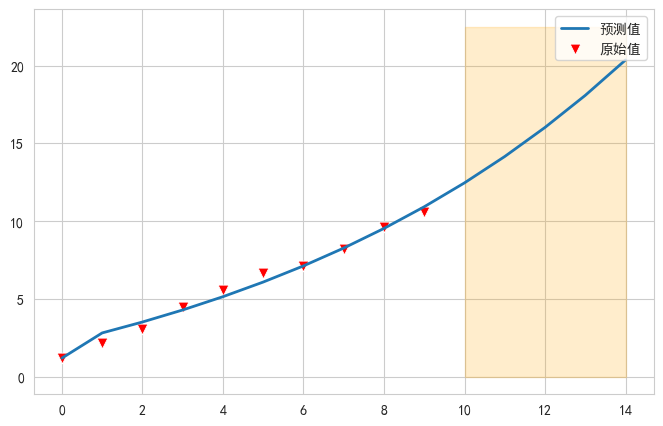

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class GrayForecast():
    # 初始化
    def __init__(self, data, n):
        """
        :param data: Series/np/list
        :param n: 预测数量
        """
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        if isinstance(data, pd.Series):
            self.data = data.values
        elif isinstance(data, np.ndarray):
            self.data = data
        elif isinstance(data, list):
            self.data = np.array(data)
        self.level_check()
        self.GM_11_build_model(n)
        print("返回值为dataframe，可通过.res_df拿到, 可通过.plot_res画预测图\n", self.res_df)

    def level_check(self):
        # 数据级比校验
        b = self.data[0]
        n = len(self.data)
        lambda_k = np.zeros(n - 1)
        while (True):
            for i in range(n - 1):
                lambda_k[i] = self.data[i] / self.data[i + 1]
            if max(lambda_k) < np.exp(2 / (n + 2)) and min(lambda_k) > np.exp(-2 / (n + 1)):
                self.c = self.data[0] - b
                print(f"完成数据 级比校验, 平移变换c={self.c}")
                break
            else:
                self.data = self.data + 0.1

    # GM(1,1)建模
    def GM_11_build_model(self, n):
        '''
            灰色预测
            x：序列，numpy对象
            n:需要往后预测的个数
        '''
        x = self.data
        # 累加生成（1-AGO）序列
        x1 = x.cumsum()
        # 紧邻均值生成序列
        z1 = (x1[:len(x1) - 1] + x1[1:]) / 2.0
        z1 = z1.reshape((len(z1), 1))
        B = np.append(-z1, np.ones_like(z1), axis=1)
        Y = x[1:].reshape((len(x) - 1, 1))
        # a为发展系数 b为灰色作用量
        [[a], [b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Y)  # 计算参数
        # 预测数据
        fit_res = [x[0]]
        for index in range(1, len(x) + n):
            fit_res.append((x[0] - b / a) * (1 - np.exp(a)) * np.exp(-a * (index)))
        # 数据还原
        self.data -= self.c
        fit_res -= self.c
        self.res_df = pd.concat([pd.DataFrame({'原始值': self.data}), pd.DataFrame({'预测值': fit_res})], axis=1)
        print(f"发展系数a={a}, 灰色作用量b={b}\n")
        self.verfify(self.data, fit_res, a)
        return self.res_df

    def verfify(self, x, predict, a):
        S1_2 = x.var()  # 原序列方差
        e = list()  # 残差序列
        for index in range(x.shape[0]):
            e.append(x[index] - predict[index])
        S2_2 = np.array(e).var()  # 残差方差
        C = S2_2 / S1_2  # 后验差比
        if C <= 0.35:
            assess = '后验差比<=0.35，模型精度等级为好'
        elif C <= 0.5:
            assess = '后验差比<=0.5，模型精度等级为合格'
        elif C <= 0.65:
            assess = '后验差比<=0.65，模型精度等级为勉强'
        else:
            assess = '后验差比>0.65，模型精度等级为不合格'
        print(f"后验差比={C}, {assess} \n")

        # 级比偏差
        a_ = (1 - 0.5 * a) / (1 + 0.5 * a)
        delta = [np.nan]
        for i in range(x.shape[0] - 1):
            delta.append(1 - a_ * (x[i] / x[i + 1]))

        self.res_df = pd.concat([self.res_df, pd.DataFrame({'残差': e}),
                                 pd.DataFrame({'相对误差': list(map(lambda x: '{:.2%}'.format(x), np.abs(e / x)))}),
                                 pd.DataFrame({'级比偏差': delta})
                                 ],
                                axis=1)

    def plot_res(self, xlabel='', ylabel=''):
        res_df = self.res_df
        f, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(x=res_df.index.tolist(), y=res_df['预测值'], linewidth=2, ax=ax, label='预测值')
        sns.scatterplot(x=res_df.index.tolist(), y=res_df['原始值'], s=60, color='r', marker='v', ax=ax, label='原始值')
        plt.fill_between(np.where(np.isnan(res_df["原始值"]))[0], y1=min(plt.yticks()[0]), y2=max(plt.yticks()[0]),
                         color='orange', alpha=0.2)
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        plt.show()


data = np.array([1.2, 2.2, 3.1, 4.5, 5.6, 6.7, 7.1, 8.2, 9.6, 10.6, 11, 12.4, 13.5, 14.7, 15.2])
x = data[0:10]  # 输入数据
gm = GrayForecast(x, 5)  # 预测后面5个数据
res_df = gm.res_df
gm.plot_res()